In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from Common import NeuralNet, TrainingConfig, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os
from datetime import datetime
import json

In [2]:
class HeatFPINN:
    def __init__(self, n_int, n_sb, n_tb, lambda_u=10, n_hidden_layers=4, neurons=20, retrain_seed=42, device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        self.dtype = torch.float32

        self.n_int = n_int
        self.n_sb = n_sb
        self.n_tb = n_tb

        # Extrema of the solution domain (t,x)
        time_domain = [0, 1]
        space_domain = [0, 1]
        self.domain_extrema = torch.tensor([time_domain, space_domain])

        # Parameter to balance the role of data and PDE
        self.lambda_u = lambda_u
        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, n_hidden_layers=n_hidden_layers, neurons=neurons, retrain_seed=retrain_seed, device=device).to(device)

        self.ms = lambda x: torch.mean(torch.square(x))
        # Create directory to save plots
        path = os.path.join('/Users/omar/Desktop/Thesis/plots', self.__class__.__name__, datetime.now().strftime('%Y-%m-%d %H-%M-%S'))
        os.makedirs(path)
        self.path = path

    # Function to linearly transform a tensor whose value is between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def save_config(self, optimizer):
        class_config = {
            'n_int': self.n_int,
            'n_sb': self.n_sb,
            'n_tb': self.n_tb,
            'lambda_u': self.lambda_u,
            'n_hidden_layers': self.approximate_solution.n_hidden_layers,
            'neurons': self.approximate_solution.neurons,
            'retrain_seed': self.approximate_solution.retrain_seed,
            'device': self.device,
            'optimizer_config': optimizer.defaults
        }
        # Save configuration in json file
        with open(f'{self.path}/config.json', 'w') as f:
            json.dump(class_config, f)

    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    def left_boundary_condition(self, t):
        return torch.zeros(t.shape[0], 1)

    def right_boundary_condition(self, t):
        return torch.zeros(t.shape[0], 1)

    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    ###############################################################################################
    # add points
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb = input_tb.to(self.dtype).to(self.device)
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)
        output_tb = output_tb.to(self.dtype).to(self.device)
        return input_tb, output_tb

    def add_spatial_boundary_points_left(self):
        x_left = self.domain_extrema[1, 0]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))
        input_sb = input_sb.to(self.dtype).to(self.device)
        input_sb_left = torch.clone(input_sb)
        input_sb_left[:, 1] = torch.full(input_sb_left[:, 1].shape, x_left)

        output_sb_left = self.left_boundary_condition(input_sb_left[:, 0]).reshape(-1, 1)
        output_sb_left = output_sb_left.to(self.dtype).to(self.device)
        return input_sb_left, output_sb_left

    def add_spatial_boundary_points_right(self):
        x_right = self.domain_extrema[1, 1]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))
        input_sb = input_sb.to(self.dtype).to(self.device)
        input_sb_right = torch.clone(input_sb)

        input_sb_right[:, 1] = torch.full(input_sb_right[:, 1].shape, x_right)

        output_sb_right = self.right_boundary_condition(input_sb_right[:, 0]).reshape(-1, 1)
        output_sb_right = output_sb_right.to(self.dtype).to(self.device)
        return input_sb_right, output_sb_right


    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        input_int = input_int.to(self.dtype).to(self.device)
        output_int = torch.zeros((input_int.shape[0], 1))
        output_int = output_int.to(self.dtype).to(self.device)
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_left, output_sb_left = self.add_spatial_boundary_points_left()
        input_sb_right, output_sb_right = self.add_spatial_boundary_points_right()
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int
        training_set_sb_left = DataLoader(torch.utils.data.TensorDataset(input_sb_left, output_sb_left), batch_size=self.n_sb, shuffle=False)
        training_set_sb_right = DataLoader(torch.utils.data.TensorDataset(input_sb_right, output_sb_right), batch_size=self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        return training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int

    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        u_pred_tb = u_pred_tb.to(self.dtype).to(self.device)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions_left(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        u_pred_sb = u_pred_sb.to(self.dtype).to(self.device)
        return u_pred_sb

    def apply_boundary_conditions_right(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        u_pred_sb = u_pred_sb.to(self.dtype).to(self.device)
        return u_pred_sb

    ################################################################################################
    def optimizer_LBFGS(self, config):
        """Create LBFGS optimizer with specified configuration."""
        return torch.optim.LBFGS(
            self.approximate_solution.parameters(),
            lr=float(config.lr),
            max_iter=config.max_iter,
            max_eval=config.max_eval,
            history_size=config.history_size,
            line_search_fn=config.line_search_fn
        )

    def optimizer_ADAM(self, lr=1e-5):
        return torch.optim.Adam(self.approximate_solution.parameters(), lr=float(lr))

# Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, train_points):
        (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right,
         inp_train_tb, u_train_tb, inp_train_int) = train_points

        # Compute boundary predictions
        u_pred_sb_left = self.apply_boundary_conditions_left(inp_train_sb_left)
        u_pred_sb_right = self.apply_boundary_conditions_right(inp_train_sb_right)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        # Validate shapes
        assert (u_pred_sb_left.shape[1] == u_train_sb_left.shape[1])
        assert (u_pred_sb_right.shape[1] == u_train_sb_right.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        # Compute residuals
        r_int = self.compute_pde_residual(inp_train_int)
        r_sb_left = u_train_sb_left - u_pred_sb_left
        r_sb_right = u_train_sb_right - u_pred_sb_right
        r_tb = u_train_tb - u_pred_tb

        # Compute individual losses
        loss_sb_left = self.ms(r_sb_left)
        loss_sb_right = self.ms(r_sb_right)
        loss_tb = self.ms(r_tb)
        loss_int = self.ms(r_int)

        # Compute boundary loss
        loss_u = loss_sb_left + loss_tb + loss_sb_right

        # Total loss with log scaling
        loss = torch.log10(self.lambda_u * loss_u + loss_int)

        return loss, loss_u, loss_int

    def enhanced_fit(self, num_epochs, optimizer, config=None, verbose=True):
        if config is None:
            config = TrainingConfig(num_epochs=num_epochs)

        self.save_config(optimizer)

        history = {
            'total_loss': [],
            'pde_loss': [],
            'boundary_loss': [],
            'learning_rate': []
        }

        # Initialize early stopping
        early_stopping = EarlyStopping(
            patience=config.early_stopping_patience,
            min_delta=config.early_stopping_min_delta
        )

        # Setup scheduler for ADAM
        is_lbfgs = isinstance(optimizer, torch.optim.LBFGS)
        scheduler = None
        if not is_lbfgs:
            scheduler = ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=config.scheduler_factor,
                patience=config.scheduler_patience,
                min_lr=config.scheduler_min_lr,
                verbose=verbose
            )

        # Get training datasets
        training_sets = self.assemble_datasets()
        training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int = training_sets

        for epoch in range(num_epochs):
            epoch_losses = []

            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

            for data in zip(training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int):
                inp_train_sb_left, u_train_sb_left = data[0]
                inp_train_sb_right, u_train_sb_right = data[1]
                inp_train_tb, u_train_tb = data[2]
                inp_train_int, _ = data[3]

                def closure():
                    if is_lbfgs:
                        optimizer.zero_grad()

                    train_points = (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right, inp_train_tb, u_train_tb, inp_train_int)

                    loss, loss_u, loss_int = self.compute_loss(train_points)
                    loss.backward()

                    epoch_losses.append({
                        'total': loss.item(),
                        'pde': torch.log10(loss_int).item(),
                        'boundary': torch.log10(loss_u).item()
                    })

                    return loss

                if is_lbfgs:
                    optimizer.step(closure)
                else:
                    optimizer.zero_grad()
                    loss = closure()
                    optimizer.step()

            # Calculate average losses
            avg_losses = {
                k: np.mean([loss[k] for loss in epoch_losses])
                for k in ['total', 'pde', 'boundary']
            }

            # Update history
            history['total_loss'].append(avg_losses['total'])
            history['pde_loss'].append(avg_losses['pde'])
            history['boundary_loss'].append(avg_losses['boundary'])
            history['learning_rate'].append(optimizer.param_groups[0]['lr'])

            # Update scheduler
            if scheduler is not None:
                scheduler.step(avg_losses['total'])

            # Print progress
            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"Total Loss: {avg_losses['total']:.6f} | "
                      f"Boundary Loss: {avg_losses['boundary']:.6f} | "
                      f"PDE Loss: {avg_losses['pde']:.6f} | "
                      f"LR: {optimizer.param_groups[0]['lr']:.6e}")

            # Early stopping
            if early_stopping(self.approximate_solution, avg_losses['total']):
                if verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch + 1}")
                early_stopping.restore_best_weights(self.approximate_solution)
                break

        if verbose:
            print(f"\nTraining completed. Final loss: {history['total_loss'][-1]:.6f}")

        return history
    ################################################################################################
    def relative_L2_error(self, n_points=10000):
        inputs = self.soboleng.draw(n_points)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5
        # print in scientific notation the L2 norm i.e. 1.234 x 10^-2
        print('L2 Relative Error Norm: {:.6e}'.format(err.item()))
        with open(f'{self.path}/relative_error.txt', 'a') as f:
            f.write('L2 Relative Error Norm: {:.6e}\n'.format(err.item()))
        return inputs, output, exact_output

    def plotting_solution(self, n_points=100000):
        inputs, output, exact_output = self.relative_L2_error(n_points)
        inputs = inputs.cpu()
        output = output.cpu()
        exact_output = exact_output.cpu()
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap='jet')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('t')
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which='both', ls=':')
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap='jet')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('t')
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which='both', ls=':')
        axs[0].set_title('Exact Solution')
        axs[1].set_title('Approximate Solution')
        plt.savefig(f'{self.path}/solution.png')
        plt.show()
        plt.close()

    def plot_training_points(self):
        # Plot the input training points
        input_sb_left, _ = self.add_spatial_boundary_points_left()
        input_sb_right_, _= self.add_spatial_boundary_points_right()
        input_tb_, _ = self.add_temporal_boundary_points()
        input_int_, _ = self.add_interior_points()

        input_sb_left_ = copy.deepcopy(input_sb_left).cpu()
        input_sb_right_ = copy.deepcopy(input_sb_right_).cpu()
        input_tb_ = copy.deepcopy(input_tb_).cpu()
        input_int_ = copy.deepcopy(input_int_).cpu()

        plt.figure(figsize=(16, 8), dpi=150)
        plt.scatter(input_sb_left_[:, 1].detach().numpy(), input_sb_left_[:, 0].detach().numpy(), label='Left Boundary Points')
        plt.scatter(input_sb_right_[:, 1].detach().numpy(), input_sb_right_[:, 0].detach().numpy(), label='Right Boundary Points')
        plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label='Interior Points')
        plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label='Initial Points')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.legend()
        plt.savefig(f'{self.path}/training_points.png')
        plt.show()


    def plot_train_loss(self, hist):
        hist = hist['total_loss']
        plt.figure(dpi=150)
        plt.grid(True, which="both", ls=":")
        plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
        plt.xscale("log")
        plt.xlabel("Epoch")
        plt.ylabel('Log10 Loss')
        plt.legend()
        plt.savefig(f'{self.path}/train_loss.png')
        plt.show()

# Testing

In [3]:
config = TrainingConfig(
    num_epochs=100,
    early_stopping_patience=20,
    max_iter=25,
)
pde = HeatFPINN(n_int=256, n_sb=64, n_tb=64)

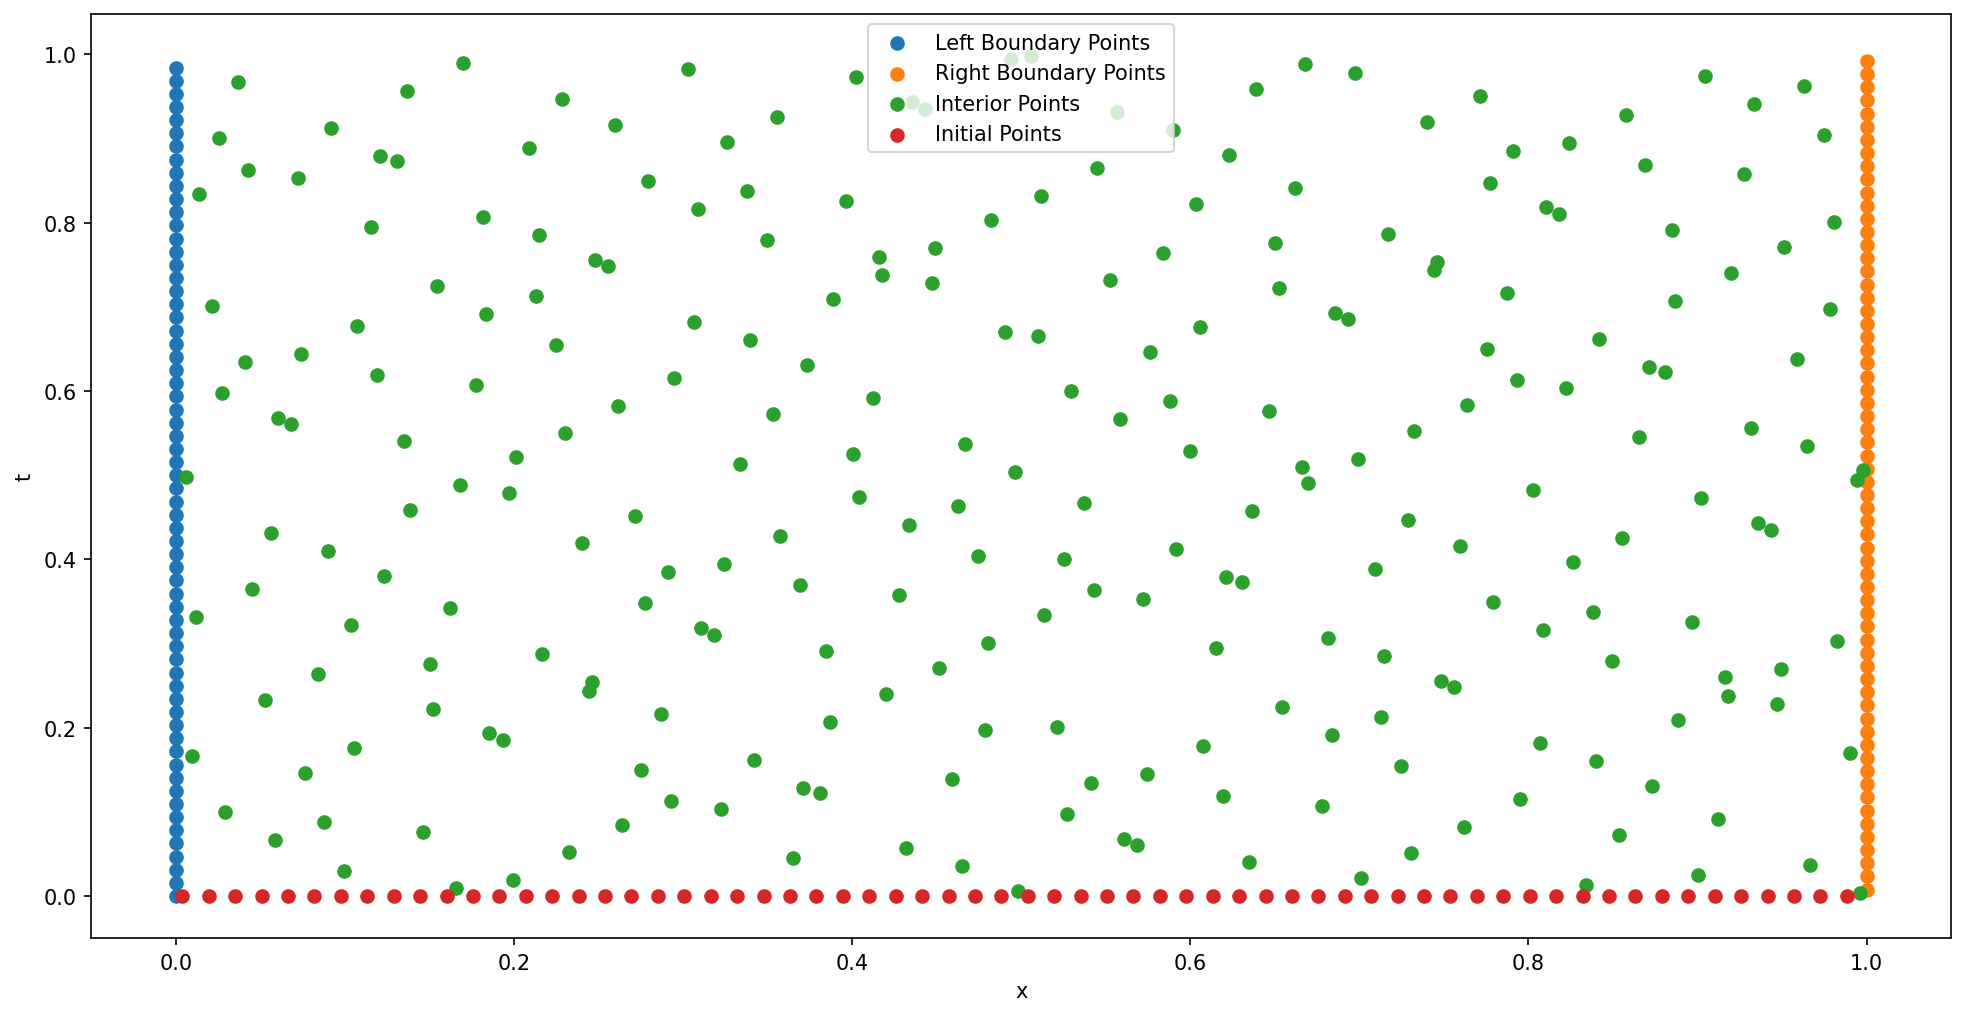

In [4]:
pde.plot_training_points()

In [5]:

optimizer = pde.optimizer_LBFGS(config)
start = time.time()
history = pde.enhanced_fit(
    num_epochs=config.num_epochs,
    optimizer=optimizer,
    config=config,
    verbose=True
)
end = time.time()
print('Time taken: ', end - start)
with open(f'{pde.path}/time.txt', 'w') as f:
    f.write('Time taken: {:.6f}'.format(end - start))


Epoch [1/100]
Total Loss: 0.033655 | Boundary Loss: -1.098102 | PDE Loss: -0.576253 | LR: 5.000000e-01

Epoch [11/100]
Total Loss: -3.878803 | Boundary Loss: -5.485743 | PDE Loss: -4.002738 | LR: 5.000000e-01

Epoch [21/100]
Total Loss: -4.925953 | Boundary Loss: -6.652051 | PDE Loss: -5.016708 | LR: 5.000000e-01

Epoch [31/100]
Total Loss: -5.220480 | Boundary Loss: -7.083696 | PDE Loss: -5.284618 | LR: 5.000000e-01

Epoch [41/100]
Total Loss: -5.411524 | Boundary Loss: -7.219804 | PDE Loss: -5.485026 | LR: 5.000000e-01

Epoch [51/100]
Total Loss: -5.620852 | Boundary Loss: -7.322375 | PDE Loss: -5.717129 | LR: 5.000000e-01

Epoch [61/100]
Total Loss: -5.727763 | Boundary Loss: -7.459027 | PDE Loss: -5.816962 | LR: 5.000000e-01

Epoch [71/100]
Total Loss: -5.792944 | Boundary Loss: -7.455073 | PDE Loss: -5.899576 | LR: 5.000000e-01

Epoch [81/100]
Total Loss: -5.881914 | Boundary Loss: -7.483964 | PDE Loss: -6.006878 | LR: 5.000000e-01

Epoch [91/100]
Total Loss: -5.970106 | Boundary

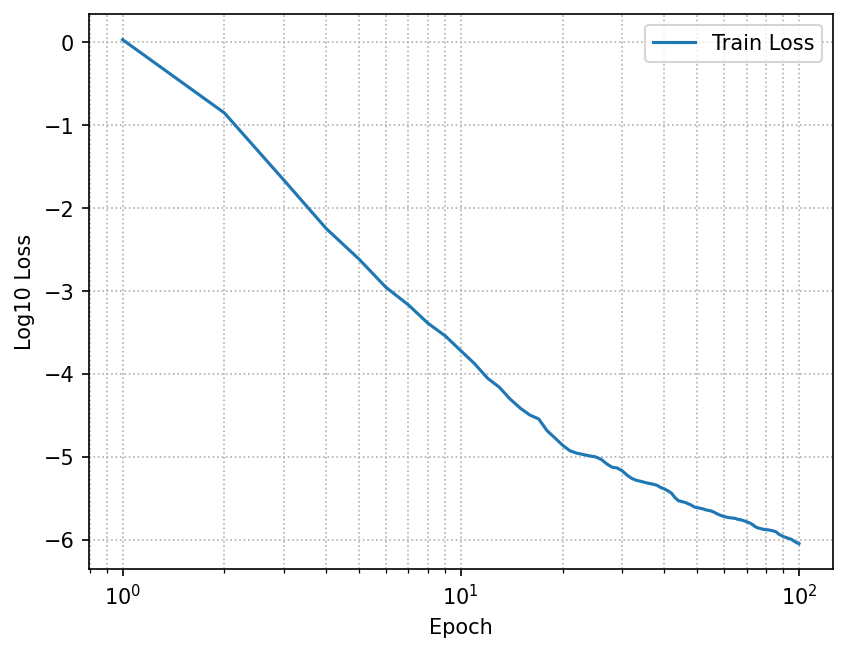

In [6]:
pde.plot_train_loss(history)

L2 Relative Error Norm: 3.240748e-04


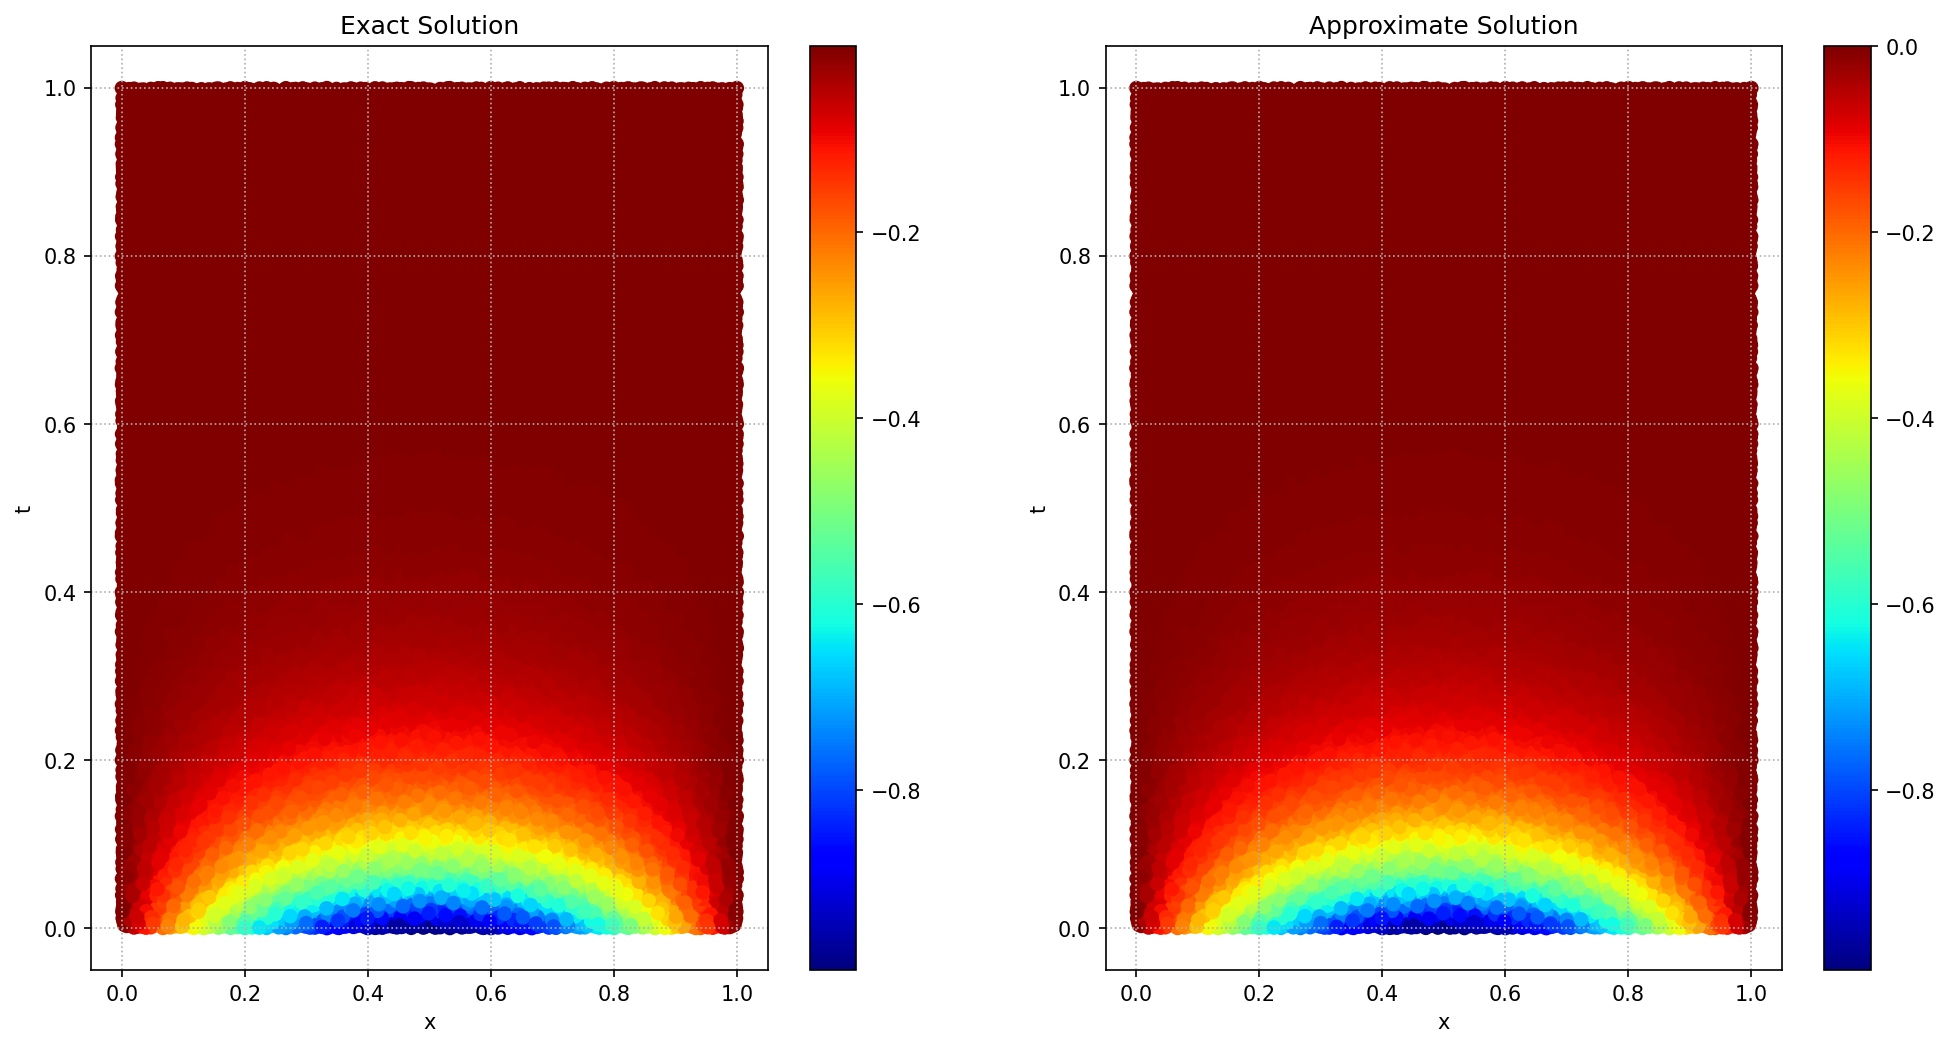

In [7]:
pde.plotting_solution(50000)